<a href="https://colab.research.google.com/github/karinaa17-spec/Tranfer_learning_Gat_x_Dog.ipynb/blob/main/Tranfer_learning_Gat_x_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.GJRF1X_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - accuracy: 0.9203 - loss: 0.1799 - val_accuracy: 0.9783 - val_loss: 0.0621
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.9793 - loss: 0.0591 - val_accuracy: 0.9781 - val_loss: 0.0621
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.9811 - loss: 0.0540 - val_accuracy: 0.9794 - val_loss: 0.0579
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.9838 - loss: 0.0478 - val_accuracy: 0.9802 - val_loss: 0.0572
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.9845 - loss: 0.0454 - val_accuracy: 0.9809 - val_loss: 0.0578
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9835 - loss: 0.0497
Test accuracy: 0.98
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 56s 73ms/step - accuracy: 0.9357 - lo

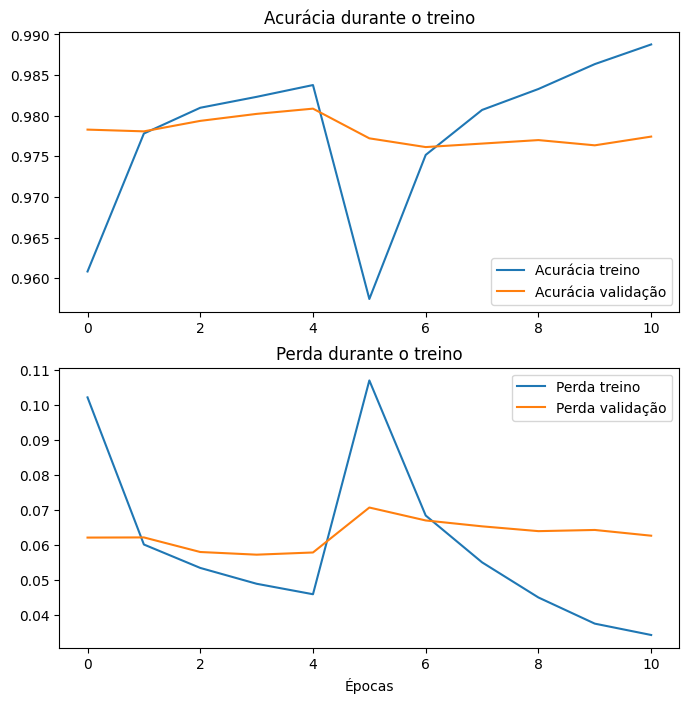

In [ ]:
# Transfer Learning para classificação gatos vs cachorros usando MobileNetV2

# 1. Importar bibliotecas
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 2. Carregar dataset cats_vs_dogs
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# 3. Pré-processamento das imagens
IMG_SIZE = 160  # MobileNetV2 espera imagens 160x160

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # normaliza para [0,1]
    return image, label

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.map(format_image, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

ds_test = ds_test.map(format_image, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# 4. Carregar modelo MobileNetV2 pré-treinado (sem a cabeça/classificador)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False  # congelar as camadas do modelo base

# 5. Adicionar camadas para classificação binária
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation='sigmoid')

# Montar o modelo final
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# 6. Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 7. Treinar o modelo
EPOCHS = 5
history = model.fit(ds_train,
                    epochs=EPOCHS,
                    validation_data=ds_test)

# 8. Avaliar o modelo
loss, accuracy = model.evaluate(ds_test)
print(f'Test accuracy: {accuracy:.2f}')

# (Opcional) 9. Fine-tuning (descongelar algumas camadas para melhorar)
base_model.trainable = True

# Congelar as primeiras camadas e descongelar as últimas 20 camadas
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # menor learning rate
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_test)

# Avaliar após fine-tuning
loss, accuracy = model.evaluate(ds_test)
print(f'Fine-tuned test accuracy: {accuracy:.2f}')

# 10. Plotar gráficos de perda e acurácia
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acurácia treino')
plt.plot(val_acc, label='Acurácia validação')
plt.legend(loc='lower right')
plt.title('Acurácia durante o treino')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda treino')
plt.plot(val_loss, label='Perda validação')
plt.legend(loc='upper right')
plt.title('Perda durante o treino')
plt.xlabel('Épocas')
plt.show()


# Nova seção